In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
# build the dataset

block_size = 3 # context length
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size # padding
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [71]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [38]:
C = torch.randn((27, 2))

In [39]:
# multidimensional embedding for each of the independent character indexes in
# rows and columns of X, our input, e.g. [27, 3]
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [40]:
W1 = torch.randn((6, 100)) # [N_context*N_emb, N_hidden]
b1 = torch.randn(100)

In [41]:
h = torch.tanh(emb.view(-1, W.shape[0]) @ W + b)

In [42]:
h

tensor([[ 0.8747,  0.8088, -0.9128,  ...,  0.7171,  0.2418,  0.9885],
        [-0.9970, -0.2490, -0.0065,  ..., -0.9626,  0.9999,  0.9863],
        [ 0.9412,  0.0517, -0.9975,  ..., -0.9867,  0.9006,  0.9856],
        ...,
        [ 0.1667,  0.9969, -0.4888,  ...,  0.9757,  0.0718,  0.9997],
        [-0.3605,  0.2546, -0.9745,  ...,  0.9941,  0.9961,  0.8548],
        [ 0.3267, -0.8743,  0.0829,  ..., -0.9997,  0.0477,  0.9793]])

In [43]:
h.shape

torch.Size([32, 100])

In [44]:
W2 = torch.randn((100, 27)) # [N_hidden, N_emb]
b2 = torch.randn(27)

In [46]:
logits = h @ W2 + b2

In [48]:
logits.shape

torch.Size([32, 27])

In [49]:
counts = logits.exp()

In [50]:
prob = counts / counts.sum(1, keepdim=True)

In [51]:
prob.shape

torch.Size([32, 27])

In [58]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.9293)

## Now made respectable

In [132]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [133]:
sum(p.nelement() for p in parameters)

3481

In [134]:
for p in parameters:
    p.requires_grad = True

In [135]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [146]:
lri = []
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2) (batch, context, N_emb)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    # lr = 0.1
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    
# print(loss.item())

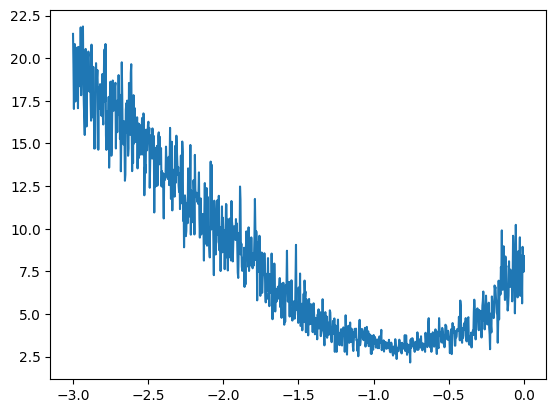

In [131]:
plt.plot(lri, lossi)

In [147]:
emb = C[X] # (32, 3, 2) (batch, context, N_emb)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3281, grad_fn=<NllLossBackward0>)